In [31]:
from pathlib import Path
import os, sys

from astropy.nddata import CCDData
from astropy.io import fits
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils import make_source_mask
from astropy.stats import sigma_clipped_stats

from photutils import aperture_photometry
from photutils import CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.aperture import CircularAperture

from matplotlib.patches import Patch
from matplotlib.lines import Line2D\

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [171]:
# cloudy_path = Path('dao_data/images/im_div_mf/cloudy/')
# clouds = ccdp.ImageFileCollection(cloudy_path)
# clouds.summary['date-obs'][-1]

In [172]:
# Defining file paths for the data bullshit ############
dark_path = Path('plaskett_calibration/darks')
flats_path = Path('plaskett_calibration/flats')
bias_path = Path('plaskett_calibration/bias')
image_path = Path('plaskett_images')

# Now taking the data bullshit and creating an image file collection #########
dark_frames = ccdp.ImageFileCollection(dark_path)
flats_frames = ccdp.ImageFileCollection(flats_path)
bias_frames = ccdp.ImageFileCollection(bias_path)
image_frames = ccdp.ImageFileCollection(image_path)



In [173]:
# Trimming the files
darks = dark_frames.files
flats = flats_frames.files
images = image_frames.files
for i in range(len(images)):
    image = CCDData.read(image_path / images[i], unit='adu')
    image_oc = ccdp.subtract_overscan(image, 
                                         overscan=image[2307:, :], 
                                         overscan_axis=0)
    image_trim = ccdp.trim_image(image_oc[:2307, :])
    image_trim.write(image_path / "images_trimmed/{}".format(images[i]), overwrite=True)
    if i < len(darks):
        dark = CCDData.read(dark_path / darks[i], unit='adu')
        dark_oc = ccdp.subtract_overscan(dark, 
                                         overscan=dark[2307:, :], 
                                         overscan_axis=0)
        dark_trim = ccdp.trim_image(dark_oc[:2307, :])
        dark_trim.write(dark_path / "darks_trimmed/{}".format(darks[i]), overwrite=True)
    if i < len(flats):
        flat = CCDData.read(flats_path / flats[i], unit='adu')
        flat_oc = ccdp.subtract_overscan(flat, 
                                         overscan=flat[2307:, :], 
                                         overscan_axis=0)
        flat_trim = ccdp.trim_image(flat_oc[:2307, :])
        flat_trim.write(flats_path / "flats_trimmed/{}".format(flats[i]), overwrite=True)

In [174]:
print(images[0])

dao_c182_2022_004803.fits.gz


In [32]:
# Redefining file paths for the data bullshit ############
dark_path = Path('plaskett_calibration/darks/darks_trimmed')
flats_path = Path('plaskett_calibration/flats/flats_trimmed')
image_path = Path('plaskett_images/images_trimmed')

# Now taking the data bullshit and creating an image file collection #########
dark_frames = ccdp.ImageFileCollection(dark_path)
flats_frames = ccdp.ImageFileCollection(flats_path)
image_frames = ccdp.ImageFileCollection(image_path)

In [176]:
dark_frames.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref
str28,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str4,str4,str11,str11,str11,str12,float64,float64,float64,float64,float64,str4,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str5,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64
dao_c182_2022_006213.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.3,2022-03-06T13:46:50,2022-03-06,13:46:50,59644.57419,dark,Dark,16:30:02.20,16:30:02.25,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48,1.0,STOP,1.8-m,DAO,NRC/HIA,0.8,0.8,293.1,3.3,3.3,86.0,1.2,8660,4,7600,1400,SDSS i prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A1,Balam,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_006213,2022-03-06T13:47:54,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_006214.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.0,2022-03-06T13:48:21,2022-03-06,13:48:21,59644.57524,dark,Dark,16:31:33.97,16:31:34.02,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48,1.0,STOP,1.8-m,DAO,NRC/HIA,0.7,0.7,269.6,3.3,3.3,86.0,1.2,8660,4,7600,1400,SDSS i prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A1,Balam,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_006214,2022-03-06T13:49:25,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_006215.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.0,2022-03-06T13:49:50,2022-03-06,13:49:50,59644.57627,dark,Dark,16:33:03.26,16:33:03.30,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48,1.0,STOP,1.8-m,DAO,NRC/HIA,0.8,0.8,248.7,3.3,3.3,86.0,1.2,8660,4,7600,1400,SDSS i prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A1,Balam,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_006215,2022-03-06T13:50:54,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_006216.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.0,2022-03-06T13:50:53,2022-03-06,13:50:53,59644.577,dark,Dark,16:34:07.43,16:34:07.48,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48,1.0,STOP,1.8-m,DAO,NRC/HIA,1.1,1.1,257.0,3.3,3.3,86.0,1.2,8660,4,7600,1400,SDSS i prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A1,Balam,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_006216,2022-03-06T13:51:58,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_006217.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.0,2022-03-06T13:52:20,2022-03-06,13:52:20,59644.57801,dark,Dark,16:35:34.19,16:35:34.24,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48,1.0,STOP,1.8-m,DAO,NRC/HIA,1.2,1.2,273.4,3.3,3.3,86.0,1.2,8660,4,7600,1400,SDSS i prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A1,Balam,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_006217,2022-03-06T13:53:24,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_006218.fits.gz,True,-64,2,1020,2307,30,E2V-1,2,2,13.5,-110.0,2022-03-06T13:53:25,2022-03-06,13:53:25,59644.57876,dark,Dark,16:36:38.89,16:36:38.93,+47:59:59.2,-00:00:00.04,90.54,0.52,2022.18,89.48

In [177]:
flats_frames.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref
str28,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str4,str8,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64
dao_c182_2022_004284.fits.gz,True,-64,2,1020,2307,1,E2V-1,2,2,13.5,-104.4,2022-02-25T02:18:55,2022-02-25,02:18:55,59635.09647,flat,SKY_FLAT,04:24:45.98,05:55:21.94,+43:00:10.8,-01:30:35.96,95.59,16.66,2022.15,73.34,1.0438,TRACK,1.8-m,DAO,NRC/HIA,0.0,0.0,118.9,-0.1,-0.1,79.0,-3.2,8500,2,4700,1500,SDSS g prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004284,2022-02-25T02:19:30,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004285.fits.gz,True,-64,2,1020,2307,1,E2V-1,2,2,13.5,-104.4,2022-02-25T02:19:33,2022-02-25,02:19:33,59635.09691,flat,SKY_FLAT,04:25:24.08,05:55:18.62,+43:00:10.8,-01:29:54.53,95.59,16.55,2022.15,73.45,1.0432,TRACK,1.8-m,DAO,NRC/HIA,0.0,0.0,118.9,-0.1,-0.1,79.0,-3.2,8500,2,4700,1500,SDSS g prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004285,2022-02-25T02:20:08,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004286.fits.gz,True,-64,2,1020,2307,1,E2V-1,2,2,13.5,-104.4,2022-02-25T02:20:11,2022-02-25,02:20:11,59635.09735,flat,SKY_FLAT,04:26:01.69,05:55:14.82,+43:00:10.8,-01:29:13.13,95.59,16.44,2022.15,73.56,1.0426,TRACK,1.8-m,DAO,NRC/HIA,0.0,0.0,118.9,-0.2,-0.2,80.0,-3.2,8500,2,4700,1500,SDSS g prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004286,2022-02-25T02:20:46,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004287.fits.gz,True,-64,2,1020,2307,2,E2V-1,2,2,13.5,-104.4,2022-02-25T02:21:01,2022-02-25,02:21:01,59635.09793,flat,SKY_FLAT,04:26:52.36,05:55:11.26,+43:00:10.8,-01:28:18.89,95.59,16.29,2022.15,73.71,1.0418,TRACK,1.8-m,DAO,NRC/HIA,0.0,0.0,118.9,-0.2,-0.2,81.0,-3.0,8500,2,4700,1500,SDSS g prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004287,2022-02-25T02:21:37,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004288.fits.gz,True,-64,2,1020,2307,2,E2V-1,2,2,13.5,-106.2,2022-02-25T02:21:39,2022-02-25,02:21:39,59635.09837,flat,SKY_FLAT,04:27:30.47,05:55:07.54,+43:00:10.7,-01:27:37.07,95.59,16.18,2022.15,73.82,1.0412,TRACK,1.8-m,DAO,NRC/HIA,0.0,0.0,118.9,-0.2,-0.2,81.0,-3.0,8500,2,4700,1500,SDSS g prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004288,2022-02-25T02:22:15,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004289.fits.gz,True,-64,2,1020,2307,2,E2V-1,2,2,13.5,-106.2,2022-02-25T02:22:17,2022-02-25,02:22:17,59635.09881,flat,SKY_FLAT,04:28:08

In [178]:
image_frames.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref
str28,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64
dao_c182_2022_004803.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:46:02,2022-02-26,03:46:02,59636.15697,object,ecl_bin(150@127),05:56:03.61,07:48:18.16,+22:41:27.8,-01:52:14.55,118.71,34.08,2022.15,55.92,1.2074,TRACK,1.8-m,DAO,NRC/HIA,0.6,0.6,272.9,1.1,1.1,80.0,-1.8,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004803,2023-02-26T03:47:37,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004804.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:47:39,2022-02-26,03:47:39,59636.15809,object,ecl_bin(150@127),05:57:40.89,07:48:17.86,+22:41:27.8,-01:50:36.97,118.71,33.87,2022.15,56.13,1.2044,TRACK,1.8-m,DAO,NRC/HIA,1.1,1.1,253.2,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004804,2023-02-26T03:49:13,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004805.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:49:15,2022-02-26,03:49:15,59636.1592,object,ecl_bin(150@127),05:59:17.19,07:48:18.04,+22:41:27.7,-01:49:00.85,118.71,33.67,2022.15,56.33,1.2016,TRACK,1.8-m,DAO,NRC/HIA,1.0,1.0,235.0,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004805,2023-02-26T03:50:50,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004806.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:50:52,2022-02-26,03:50:52,59636.16032,object,ecl_bin(150@127),06:00:53.48,07:48:17.79,+22:41:27.7,-01:47:24.30,118.71,33.47,2022.15,56.53,1.1987,TRACK,1.8-m,DAO,NRC/HIA,0.7,0.7,225.4,1.1,1.1,79.0,-2.0,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004806,2023-02-26T03:52:26,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004807.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-109.6,2022-02-26T03:52:28,2022-02-26,03:52:28,59636.16144,object,ecl_bin(150@127),06:02:30.76,07:48:18.29,+22:41:27.7,-01:45:47.52,118.71,33.27,2022.15,56.73,1.196,TRACK,1.8-m,DAO,NRC/HIA,1.0,1.0,247.7,1.1,1.1,79.0,-2.0,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004807,2023-02-26T03:54:02,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0
dao_c182_2022_004808.fits.gz,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-109.3,2022-02-26T03:54:04,2022

In [179]:
# The Hunt For the Exposure;  it's unimportant at this point

# image_name = 'dao_c182_2022_006213.fits.gz'.rstrip()

# image_path = Path(dark_path) / image_name

# hdu_list = fits.open(image_path)
# hdu_list.info()

# hdu = hdu_list[0]
# hdu.header


# with fits.open(all_flats[9]) as hdu_flats:
#     hdu_flats.verify("fix")
# hdu_flats = fits.open(all_flats[10])
# hdu_flats.info()

# hdu = hdu_flats[0]
# hdu.header['EXPOSURE']
# hdul[0].header

In [180]:
# METHOD 2: ##########################

# A) Creating Raw Master Dark by combining all dark frames
calibrated_darks = dark_frames.files_filtered(include_path=True)

raw_master_dark = ccdp.combine(calibrated_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             unit='adu'
                            )

# Saving the file (if I run this uncommented after file already created, it gets angry)
raw_master_dark.meta["combined"] = True

raw_master_dark.write('plaskett_calibration/raw_master_dark.fits')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
['plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004284.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004285.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004286.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004287.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004288.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004289.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004290.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004291.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004292.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004293.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004294.fits.gz', 'plaskett_calibration/flats/flats_trimmed/dao_c182_2022_004295.fits.gz', 'plas

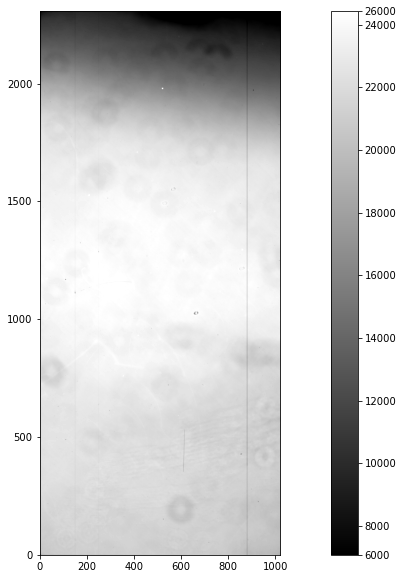

In [181]:
#print(raw_master_dark)
#print(type(raw_master_dark))
# B1) Subtracting Raw Master Dark from each flat frame:
from astropy.io import fits as pyfits

a_flat = CCDData.read(flats_frames.files_filtered(include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

all_flats = flats_frames.files_filtered(include_path=True)
print(all_flats)
print(type(all_flats))

def subtractImg(fout, fitsToSubtract, filelist): # Slightly modified Boley function
    '''takes(fout,fitsToSubtract,filelist)  '''
    import pdb
    hdulref = fits.open(fitsToSubtract)
    head = hdulref[0].header
    refdata = hdulref[0].data
    hdulref.close()

    #fh = open(filelist, "r") 
    iter = 0
    #for line in fh:
    for line in filelist: # This is basically all I changed
        fpath = line.rstrip()
        hdul = fits.open(fpath)

        head = hdul[0].header
        imgdata = hdul[0].data

        Ndata = imgdata.size

        Nref = refdata.size

        if not Ndata == Nref:
            print("Mismatch between data {} and reference {}".format(Ndata, Nref))
            sys.exit()

        NY, NX = imgdata.shape

        corrected = imgdata * 0
        for j in range(NY):
            for i in range(NX):
                if refdata[j][i] > imgdata[j][i]:
                    corrected[j][i] = 0
                else:
                    corrected[j][i] = imgdata[j][i] - refdata[j][i]

        head.set('comment', 'Subtracted {} from file {}'.format(fitsToSubtract, fpath))
        hdul[0].data = corrected

        hdul.writeto(fout + "-" + repr(iter).zfill(3) + ".fits", overwrite=True)
        hdul.close()
        iter += 1


subtractImg("plaskett_calibration/flats/flats_trimmed/flats_minus_rmd/flats_minus_rmd", 
            'plaskett_calibration/raw_master_dark.fits', 
            all_flats)       


In [182]:
# B2) Combining flats - rmd into Master Flat:
def inv_median(a):
    return 1 / np.median(a)

flats_rmd_path = flats_path / "flats_minus_rmd"
flats_rmd_frames = ccdp.ImageFileCollection(flats_rmd_path)
flats_minus_rmd = flats_rmd_frames.files_filtered(include_path=True)
master_flat = ccdp.combine(flats_minus_rmd,
                             method='median',scale=inv_median,
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             unit='adu'
                            )

# Saving the file (if I run this uncommented after file already created, it gets angry)
master_flat.meta["combined"] = True

master_flat.write('plaskett_calibration/master_flat.fits')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [183]:
CCDData.read('plaskett_calibration/master_flat.fits').data.min()

0.0

In [184]:
# C3) Subtracting raw master dark from each science frame:
all_images = image_frames.files_filtered(include_path=True)

subtractImg("plaskett_images/images_trimmed/im_minus_rmd/im_minus_rmd", 
            "plaskett_calibration/raw_master_dark.fits", all_images) 

In [189]:
# C4) Attempt at dividing im_minus_rmd files by master flat:

def divImg(fout, fitsToDivide, filelist):  # Literally Boley's - func swtiched to /
    '''takes(fout,fitsToSubtract,filelist)  '''

    hdulref = fits.open(fitsToDivide)
    head = hdulref[0].header
    refdata = hdulref[0].data
    hdulref.close()

    #fh = open(filelist, "r")
    iter = 0
    #for line in fh:
    for line in filelist:
        fpath = line.rstrip()
        hdul = fits.open(fpath)

        head = hdul[0].header
        imgdata = hdul[0].data

        Ndata = imgdata.size

        Nref = refdata.size

        if not Ndata == Nref:
            print("Mismatch between data {} and reference {}".format(Ndata, Nref))
            sys.exit()

        NY, NX = imgdata.shape

        corrected = imgdata * 0
        for j in range(NY):
            for i in range(NX):
                if refdata[j][i] == 0: # The most notable change I made
                    corrected[j][i] = 0
                else:
                    corrected[j][i] = imgdata[j][i] / refdata[j][i]

        head.set('comment', 'Divided {} from file {}'.format(fitsToDivide, fpath))
        hdul[0].data = corrected

        hdul.writeto(fout + "-" + repr(iter).zfill(3) + ".fits")
        hdul.close()
        iter += 1
        
im_rmd_path = image_path / "im_minus_rmd"
im_rmd_frames = ccdp.ImageFileCollection(im_rmd_path)
all_im_minus_rmd = im_rmd_frames.files_filtered(include_path=True)

        
divImg("plaskett_images/images_trimmed/processed_images/proc_im",
       "plaskett_calibration/master_flat.fits", all_im_minus_rmd)

# Data analysis

## Background estimation

All of these notes are copied from https://buildmedia.readthedocs.org/media/pdf/photutils/v0.3/photutils.pdf

Having an accurate estimate of the background noise is important for determining the significance of source detections and for estimating photometric errors.

Unfortunately, accurate background and background noise estimation is a difficult task. Further, because astronomical images can cover a wide variety of scenes, there is not a single background estimation method that will always be applicable. Photutils provides tools for estimating the background and background noise in your data, but they will likely require some tweaking to optimize the background estimate for your data.

If the background level and noise are relatively constant across an image, the simplest way to estimate these values is to derive scalar quantities using simple approximations. Of course, when computing the image statistics one must take into account the astronomical sources present in the images, which add a positive tail to the distribution of pixel intensities. For example, one may consider using the image median as the background level and the image standard deviation as the 1-sigma background noise, but the resulting values are obviously biased by the presence of real sources.

A slightly better method involves using statistics that are robust against the presence of outliers, such as the biweight location for the background level and biweight midvariance or median absolute deviation (MAD) for the background noise estimation. However, for most astronomical scenes these methods will also be biased by the presence of astro- nomical sources in the image.


In [38]:
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
%matplotlib inline

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


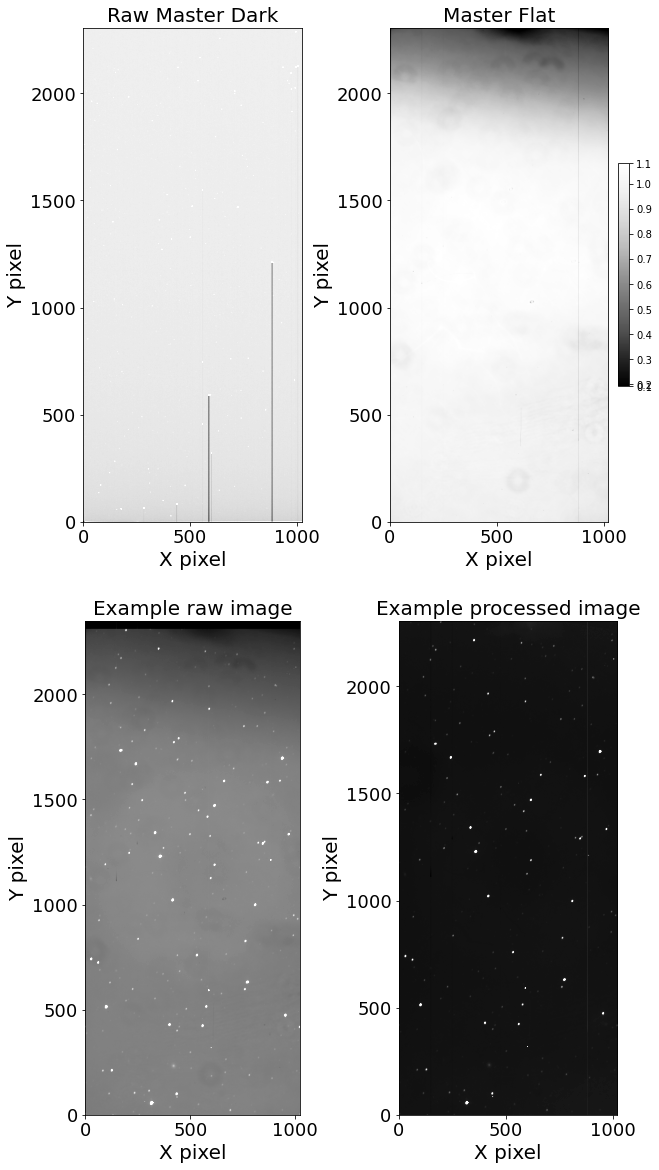

In [39]:
rmd = CCDData.read("plaskett_calibration/raw_master_dark.fits")
mf = CCDData.read("plaskett_calibration/master_flat.fits", unit='adu')
exraw = CCDData.read('plaskett_images/dao_c182_2022_004803.fits.gz', unit='adu')
exproc = CCDData.read(image_path / "processed_images/proc_im-000.fits", unit='adu')
fig, ax = plt.subplots(2,2,figsize=(10,20))
show_image(rmd, cmap='Greys_r', percl=99.9, fig=fig, ax=ax[0,0], show_colorbar=False)
ax[0,0].set_title('Raw Master Dark', fontsize=20)
show_image(mf, cmap='Greys_r', percl=99.9, fig=fig, ax=ax[0,1])
ax[0,1].set_title('Master Flat', fontsize=20)
show_image(exraw, cmap='Greys_r', percl=99.9, fig=fig, ax=ax[1,0], show_colorbar=False)
ax[1,0].set_title('Example raw image', fontsize=20)
show_image(exproc, cmap='Greys_r', percl=99.95, fig=fig, ax=ax[1,1], show_colorbar=False)
ax[1,1].set_title('Example processed image', fontsize=20)
norm = ImageNormalize(stretch=SqrtStretch())
for i in range(2):
    for j in range(2):
        ax[i,j].tick_params(labelsize=18)
        ax[i,j].set_xlabel('X pixel', fontsize=20)
        ax[i,j].set_ylabel('Y pixel', fontsize=20)
plt.subplots_adjust(wspace=0.3)
plt.savefig("RMD_MF_Img-Comp.jpg")

In [6]:
aimgf2.summary['date-obs'][-1]

NameError: name 'aimgf2' is not defined

In [40]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(exproc, sigma=3.0)#, iters=5)
print((mean, median, std))

(2084.672915429553, 2082.747034648666, 49.65068406765226)


In [41]:
from photutils import make_source_mask
from astropy.stats import sigma_clipped_stats
mask = make_source_mask(exproc, nsigma=3, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(exproc, sigma=4.0, mask=mask)
print((mean, median, std))


(2082.196028255338, 2080.9296680792518, 48.98184236176966)


In [42]:
from photutils.detection import DAOStarFinder
pathway = image_path / "processed_images"
imframe = ccdp.ImageFileCollection(pathway)
imframes = imframe.files_filtered(include_path=True)[:10]
counts = []
median_bg = []
std_bg = []
for frame in imframes: 
    mask = make_source_mask(exproc, nsigma=3, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(exproc, sigma=4.0, mask=mask)
    median_bg.append(median)
    std_bg.append(std)
    daofind = DAOStarFinder(fwhm=3.0, threshold=500.*std)  
    sources = daofind(exproc - median)  
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output
    source = sources[(sources['ycentroid']>=1500)]#&(sources['ycentroid']<=600)]
    counts.append(np.mean(source['peak'].value))
#     print(sources) 

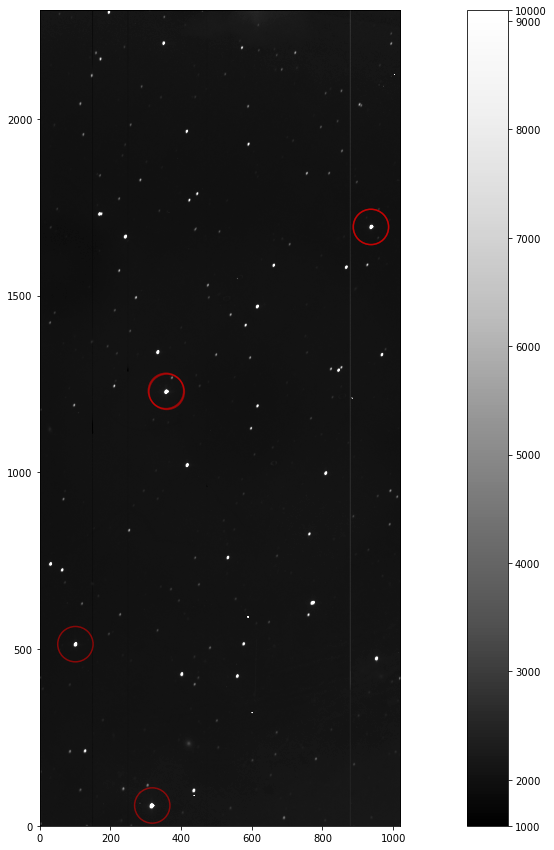

In [43]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=50.);
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(figsize=(30,15))
#plt.imshow(exproc, cmap='Greys_r', origin='lower', norm=norm,
#           interpolation='nearest')
show_image(exproc, cmap='Greys_r', percl=99.95, fig=fig, ax=ax)
apertures.plot(color='r', lw=1.5, alpha=0.5);
# fig.savefig("Identified_DAO_Stars.jpg")

In [44]:
xpixels = sources['xcentroid'].value.astype(int)
ypixels = sources['ycentroid'].value.astype(int)
xpixels

array([318, 100, 359, 357, 937, 936])

In [45]:
xindex0 = np.digitize(xpixels, bins=np.arange(0,1000, 100))
yindex0 = np.digitize(ypixels, bins=np.arange(0,2000, 100))

In [ ]:
# Separating Day 1 and Day 2 images
proc_frames = ccdp.ImageFileCollection(image_path / "processed_images", 
                                       keywords='*')

for hdu, fname in proc_frames.hdus(return_fname=True):
    if hdu.header['UT-DATE'] == "2022-02-26":
        hdu.writeto(image_path / "processed_images/day1" / fname)
    else:
         hdu.writeto(image_path / "processed_images/day2" / fname)

In [46]:
img_path1 = Path(image_path / 'processed_images/day1/')
imgf1 = ccdp.ImageFileCollection(img_path1)
img_path2 = Path(image_path / 'processed_images/day2/')
imgf2 = ccdp.ImageFileCollection(img_path2)
imgf1.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref,comment
str16,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,str246
proc_im-000.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:46:02,2022-02-26,03:46:02,59636.15697,object,ecl_bin(150@127),05:56:03.61,07:48:18.16,+22:41:27.8,-01:52:14.55,118.71,34.08,2022.15,55.92,1.2074,TRACK,1.8-m,DAO,NRC/HIA,0.6,0.6,272.9,1.1,1.1,80.0,-1.8,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004803,2023-02-26T03:47:37,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004803.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-000.fits"
proc_im-001.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:47:39,2022-02-26,03:47:39,59636.15809,object,ecl_bin(150@127),05:57:40.89,07:48:17.86,+22:41:27.8,-01:50:36.97,118.71,33.87,2022.15,56.13,1.2044,TRACK,1.8-m,DAO,NRC/HIA,1.1,1.1,253.2,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004804,2023-02-26T03:49:13,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004804.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-001.fits"
proc_im-002.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:49:15,2022-02-26,03:49:15,59636.1592,object,ecl_bin(150@127),05:59:17.19,07:48:18.04,+22:41:27.7,-01:49:00.85,118.71,33.67,2022.15,56.33,1.2016,TRACK,1.8-m,DAO,NRC/HIA,1.0,1.0,235.0,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004805,2023-02-26T03:50:50,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004805.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-002.fits"
proc_im-003.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:50:52,2022-02-26,03:50:52,59636.16032,object,ecl_bin(150@127),06:00:53.48,07:48:17.79,+22:41:27.7,-01:47:24.30,118.71,33.47,2022.15,56.53,1.1987,TRACK,1.8-m,DAO,NRC/HIA,0.7,0.7,225.4,1.1,1.1,79.0,-2.0,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004806,2023-02-26T03:52:26,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,

In [31]:
imgf2.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref,comment
str16,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,str246
proc_im-212.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:36:16,2022-03-04,04:36:16,59642.19185,object,ecl_bin(150@301),07:10:05.41,07:48:17.99,+22:41:27.6,-00:38:12.57,144.39,26.92,2022.17,63.08,1.1216,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,129.7,1.6,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005162,2023-03-04T04:37:51,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005162.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-212.fits"
proc_im-213.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:37:53,2022-03-04,04:37:53,59642.19297,object,ecl_bin(150@301),07:11:42.21,07:48:17.78,+22:41:27.7,-00:36:35.56,144.39,26.83,2022.17,63.17,1.1207,TRACK,1.8-m,DAO,NRC/HIA,3.7,3.7,130.6,1.3,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005163,2023-03-04T04:39:27,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005163.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-213.fits"
proc_im-214.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:39:29,2022-03-04,04:39:29,59642.19409,object,ecl_bin(150@301),07:13:19.00,07:48:17.53,+22:41:27.7,-00:34:58.53,144.39,26.75,2022.17,63.25,1.1198,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,128.8,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005164,2023-03-04T04:41:04,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005164.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-214.fits"
proc_im-215.fits,True,-64,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:41:06,2022-03-04,04:41:06,59642.19521,object,ecl_bin(150@301),07:14:55.78,07:48:17.31,+22:41:27.7,-00:33:21.52,144.39,26.67,2022.17,63.33,1.119,TRACK,1.8-m,DAO,NRC/HIA,3.2,3.2,134.0,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005165,2023-03-04T04:42:40,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXE

## Aligned images in AstroImageJ

In [47]:
aimg_path1 = Path(image_path / 'processed_images/aligned/day1/')
aimgf1 = ccdp.ImageFileCollection(aimg_path1)
aimg_path2 = Path(image_path / 'processed_images/aligned/day2/')
aimgf2 = ccdp.ImageFileCollection(aimg_path2)

In [48]:
aimgf2.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref,x_shift,y_shift,comment
str23,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,int64,int64,str246
aligned_proc_im212.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:36:16,2022-03-04,04:36:16,59642.19185,object,ecl_bin(150@301),07:10:05.41,07:48:17.99,+22:41:27.6,-00:38:12.57,144.39,26.92,2022.17,63.08,1.1216,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,129.7,1.6,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005162,2023-03-04T04:37:51,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005162.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-212.fits"
aligned_proc_im213.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:37:53,2022-03-04,04:37:53,59642.19297,object,ecl_bin(150@301),07:11:42.21,07:48:17.78,+22:41:27.7,-00:36:35.56,144.39,26.83,2022.17,63.17,1.1207,TRACK,1.8-m,DAO,NRC/HIA,3.7,3.7,130.6,1.3,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005163,2023-03-04T04:39:27,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,-1,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005163.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-213.fits"
aligned_proc_im214.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:39:29,2022-03-04,04:39:29,59642.19409,object,ecl_bin(150@301),07:13:19.00,07:48:17.53,+22:41:27.7,-00:34:58.53,144.39,26.75,2022.17,63.25,1.1198,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,128.8,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005164,2023-03-04T04:41:04,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,-2,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005164.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-214.fits"
aligned_proc_im215.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:41:06,2022-03-04,04:41:06,59642.19521,object,ecl_bin(150@301),07:14:55.78,07:48:17.31,+22:41:27.7,-00:33:21.52,144.39,26.67,2022.17,63.33,1.119,TRACK,1.8-m,DAO,NRC/HIA,3.2,3.2,134.0,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005165,2023-03-04T04:42:40,suboscan,"ccd=<CCDData>, overscan=<CCDD

In [49]:
tobs2 = np.array(aimgf2.summary['date-obs'].value)
hr2 = []
min2 = []
sec2 = []
for t in tobs2:
    hr = t[11:13]
    minute = t[14:16]
    sec = t[17:19]
    hr2.append(hr)
    min2.append(minute)
    sec2.append(sec)
hr2 = np.array(hr2).astype(float)
min2 = np.array(min2).astype(float)
sec2 = np.array(sec2).astype(float)
time2 = (hr2-hr2.min())*60 + min2 + sec2/60

In [50]:
tobs1 = np.array(aimgf1.summary['date-obs'].value)
hr1 = []
min1 = []
sec1 = []
for t in tobs1:
    hr = t[11:13]
    minute = t[14:16]
    sec = t[17:19]
    hr1.append(hr)
    min1.append(minute)
    sec1.append(sec)
hr1 = np.array(hr1).astype(float)
min1 = np.array(min1).astype(float)
sec1 = np.array(sec1).astype(float)
time1 = (hr1-hr1.min())*60 + min1 + sec1/60

## Day 1 analysis:

In [51]:
aimgf1.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref,x_shift,y_shift,comment
str23,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,int64,int64,str246
aligned_proc_im000.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:46:02,2022-02-26,03:46:02,59636.15697,object,ecl_bin(150@127),05:56:03.61,07:48:18.16,+22:41:27.8,-01:52:14.55,118.71,34.08,2022.15,55.92,1.2074,TRACK,1.8-m,DAO,NRC/HIA,0.6,0.6,272.9,1.1,1.1,80.0,-1.8,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004803,2023-02-26T03:47:37,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004803.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-000.fits"
aligned_proc_im001.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:47:39,2022-02-26,03:47:39,59636.15809,object,ecl_bin(150@127),05:57:40.89,07:48:17.86,+22:41:27.8,-01:50:36.97,118.71,33.87,2022.15,56.13,1.2044,TRACK,1.8-m,DAO,NRC/HIA,1.1,1.1,253.2,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004804,2023-02-26T03:49:13,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,2,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004804.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-001.fits"
aligned_proc_im002.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:49:15,2022-02-26,03:49:15,59636.1592,object,ecl_bin(150@127),05:59:17.19,07:48:18.04,+22:41:27.7,-01:49:00.85,118.71,33.67,2022.15,56.33,1.2016,TRACK,1.8-m,DAO,NRC/HIA,1.0,1.0,235.0,1.1,1.1,79.0,-1.9,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004805,2023-02-26T03:50:50,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,4,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_004805.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-002.fits"
aligned_proc_im003.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-110.3,2022-02-26T03:50:52,2022-02-26,03:50:52,59636.16032,object,ecl_bin(150@127),06:00:53.48,07:48:17.79,+22:41:27.7,-01:47:24.30,118.71,33.47,2022.15,56.53,1.1987,TRACK,1.8-m,DAO,NRC/HIA,0.7,0.7,225.4,1.1,1.1,79.0,-2.0,8619,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_004806,2023-02-26T03:52:26,suboscan,"ccd=<CCDData>, overscan=<CC

In [52]:
# Initial guess:
target = (614,1187)
comp = [(357,1228), (614,1468), (660,1585)]
ourstars = [(614,1187), (357,1228), (614,1468), (660,1585)]



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


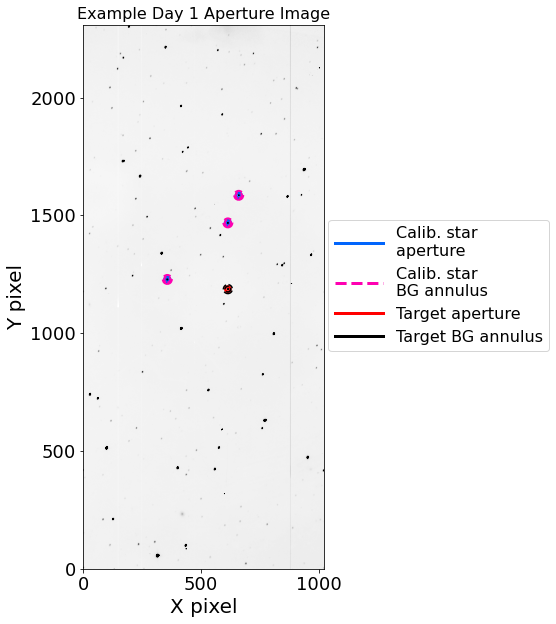

In [53]:
exproc = CCDData.read(aimg_path1/aimgf1.files[0], unit='adu')
fig, ax = plt.subplots(figsize=(10,10))
show_image(exproc, cmap='Greys', percl=99.9, fig=fig, ax=ax, show_colorbar=False)
apertures = CircularAperture(target, r=11.);
apertures.plot(color='r', lw=2.5, alpha=1);
apertures = CircularAperture(target, r=12.);
apertures.plot(color='xkcd:black', ls='--', lw=1.5, alpha=1);
apertures = CircularAperture(target, r=19.);
apertures.plot(color='xkcd:black', lw=1.5, ls='--', alpha=1);

rvals = [11, 11, 11, 11]
for r, compstar in enumerate(comp):
    apertures = CircularAperture(compstar, r=rvals[r]);
    apertures.plot(color='xkcd:bright blue', lw=3, alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r]+2);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r]+8);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
#plt.xlim(250,750)
#plt.ylim(1100,1700)
ax.tick_params(labelsize=18)
plt.xlabel('X pixel', fontsize=20)
plt.ylabel('Y pixel', fontsize=20)
plt.title("Example Day 1 Aperture Image", fontsize=16)
legend_elements = [Line2D([0], [0], lw=3, color='xkcd:bright blue', ls='-', label='Calib. star\naperture'),
                   Line2D([0], [0], lw=3, color='xkcd:bright pink', ls='--', label='Calib. star\nBG annulus'),
                   Line2D([0], [0], color='r', lw=3, label='Target aperture'),
                  Line2D([0], [0], color='k', lw=3, label='Target BG annulus')]

ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor= (1.02, 0.4), ncol=1,
            borderaxespad=0, frameon=True, handlelength=3, fontsize=16)
plt.savefig("Aperture_Image_Full.jpg")

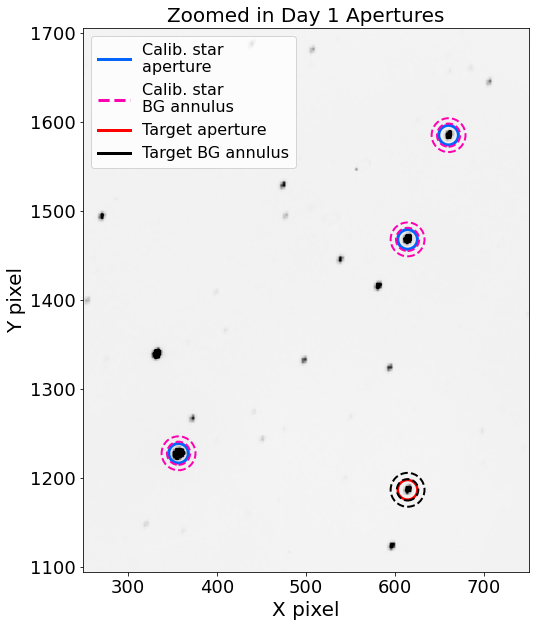

In [54]:
# Zoomed in:

fig, ax = plt.subplots(figsize=(10,10))
show_image(exproc, cmap='Greys', percl=99.9, fig=fig, ax=ax, show_colorbar=False)
apertures = CircularAperture(target, r=11.);
apertures.plot(color='r', lw=2.5, alpha=1);
apertures = CircularAperture(target, r=12.);
apertures.plot(color='k', ls='--', lw=2, alpha=1);
apertures = CircularAperture(target, r=19.);
apertures.plot(color='k', lw=2, ls='--', alpha=1);

rvals = [11, 11, 11, 11]
for r, compstar in enumerate(comp):
    apertures = CircularAperture(compstar, r=rvals[r+1]);
    apertures.plot(color='xkcd:bright blue', lw=3, alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r+1]+2);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r+1]+8);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
plt.xlim(250,750)
plt.ylim(1095,1705)
ax.tick_params(labelsize=18)
plt.xlabel('X pixel', fontsize=20)
plt.ylabel('Y pixel', fontsize=20)
plt.title("Zoomed in Day 1 Apertures", fontsize=20)
legend_elements = [Line2D([0], [0], lw=3, color='xkcd:bright blue', ls='-', label='Calib. star\naperture'),
                   Line2D([0], [0], lw=3, color='xkcd:bright pink', ls='--', label='Calib. star\nBG annulus'),
                   Line2D([0], [0], color='r', lw=3, label='Target aperture'),
                  Line2D([0], [0], color='k', lw=3, label='Target BG annulus')]

# plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor= (0.04, 1.01), ncol=2,
#             borderaxespad=0, frameon=True, handlelength=3, fontsize=16)
plt.legend(handles=legend_elements, loc='best', fontsize=16)
plt.savefig("day1_apertures_zoomed.jpg")

In [55]:
# apertures = CircularAperture(ourstars, r=10)

# # testing this method from a website (don't use this one!)


# annulus_apertures = CircularAnnulus(ourstars, r_in=11., r_out=20.)
# aperstats = ApertureStats(exproc.data, annulus_apertures)
# bkg_mean = aperstats.mean
# print(bkg_mean)  
# phot_table = aperture_photometry(exproc, apertures)
# for col in phot_table.colnames:
#     phot_table[col].info.format = '%.8g'  # for consistent table output
# print(phot_table)
# aperture_area = apertures.area_overlap(exproc)
# total_bkg = bkg_mean * aperture_area
# phot_bkgsub = phot_table['aperture_sum'].value - total_bkg

# phot_table['total_bkg'] = total_bkg
# phot_table['aperture_sum_bkgsub'] = phot_bkgsub
# for col in phot_table.colnames:
#     phot_table[col].info.format = '%.8g'  # for consistent table output
# print(phot_table)

In [56]:
import pandas as pd
data = pd.DataFrame(columns=['time', 'star', 'aperture_sum', 'total_bkg_local', 
                             'aperture_sum_bkgsub_local', 'aperture_sum_bkgsub_global', 'aperstats_sum'])
apertures = CircularAperture(ourstars, r=11.);
annulus_apertures = CircularAnnulus(ourstars, r_in=12., r_out=19.)
bgmeans = []
bgstds = []

for i in range(len(aimgf1.files)):
    exproc = CCDData.read(aimg_path1/aimgf1.files[i], unit='adu')

    mask = make_source_mask(exproc, nsigma=3, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(exproc, sigma=4.0, mask=mask)
    bgmeans.append(mean)
    bgstds.append(std)
    phot_table_local = aperture_photometry(exproc - median, apertures)
    
    aperstats = ApertureStats(exproc.data, annulus_apertures)
    sums = aperstats.sum
    bkg_mean = aperstats.mean
    print(bkg_mean)
    phot_table = aperture_photometry(exproc, apertures)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    aperture_area = apertures.area_overlap(exproc)
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'].value - total_bkg

    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    
    dat = np.array([time1[i]*np.ones(4), phot_table['id'].value.astype(int), phot_table['aperture_sum'].value.astype(float),
                    phot_table['total_bkg'].value.astype(float), phot_table['aperture_sum_bkgsub'].value.astype(float), 
                    phot_table_local['aperture_sum'].value.astype(float), sums]).T
    data = data.append(pd.DataFrame(dat, columns=data.columns))

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2043.31826942 2156.18279781 2110.44417661 2087.88048624]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2030.49552935 2141.33412259 2097.83558832 2082.46825409]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2184.52915919 2303.57478403 2261.88126923 2242.29066503]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2300.18843824 2412.07903662 2373.25085414 2356.24705576]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2292.53815691 2413.32443415 2367.29915885 2349.23184701]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2206.71967227 2323.66077547 2279.35678313 2260.85567102]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2105.02435108 2225.84227345 2174.06298189 2154.37492832]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2087.11582308 2208.70481305 2152.93634175 2135.09951516]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1919.37674624 2040.15795615 1983.47144655 1966.21924183]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1850.30943227 1971.26433102 1916.04979936 1899.07476221]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1782.14045449 1905.49130409 1847.3566749  1826.21334555]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1770.92474968 1892.79998833 1835.1963375  1816.97954293]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1732.52692715 1859.7227675  1799.75817711 1781.21911107]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1745.64285988 1869.99499441 1811.27617131 1793.6756001 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1709.09287226 1840.36294733 1776.37051853 1758.19968556]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1716.933433   1849.15594624 1784.72038038 1764.99856354]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1721.47650129 1849.91802428 1788.418418   1769.69625606]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1718.29654339 1847.22796986 1778.00837317 1757.67159112]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1694.49581341 1827.96191211 1752.05433673 1732.95305988]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1679.27649387 1813.51735332 1741.86027616 1720.8047331 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1740.10754235 1872.58645399 1802.26086798 1781.97857081]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1725.77310411 1861.2080488  1788.39771892 1769.25603645]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1719.15470212 1849.17690455 1780.29384613 1760.60006856]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1767.73813026 1895.35247146 1826.49845443 1806.51172993]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1803.54483263 1938.05780863 1867.49299905 1848.80234155]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1852.98155762 1975.94906137 1918.81213822 1902.38964968]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1842.23570535 1960.76792872 1905.22750109 1886.4440863 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1770.94638736 1896.23993009 1831.50326148 1814.06335059]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1769.19357637 1890.55229773 1828.18269295 1810.39329476]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1854.44637991 1982.54066893 1917.91541414 1899.45788503]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1863.69738415 1989.01607567 1925.49425684 1909.28001297]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1727.11478158 1852.49843793 1786.08616851 1763.00060432]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1773.11944917 1900.35661653 1829.64356143 1810.45370767]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1828.2384514  1949.37770879 1887.22063925 1867.353203  ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1644.26258371 1768.24548216 1699.46086688 1676.07651449]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1700.56056267 1822.31197481 1753.15592832 1730.91240639]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1721.99330955 1844.2070474  1775.13834789 1755.41091511]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1858.83433355 1977.81539793 1915.34008008 1892.42996269]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1842.10922561 1960.48641205 1897.68586483 1876.51874134]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1699.0348273  1814.69241599 1751.78958804 1731.48817586]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1597.51754246 1717.45369933 1650.34525938 1626.40522713]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1566.05564153 1692.52273542 1617.92679436 1592.36125964]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1588.45896521 1711.38142182 1640.35895964 1617.87191577]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1608.11867754 1734.4657866  1661.30588638 1637.26365307]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1654.12143725 1782.66308381 1711.20713895 1684.49207199]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1797.4317579  1917.54216482 1850.80921084 1828.45852466]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1827.57600829 1954.9453565  1881.71856335 1856.0084523 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1800.46756673 1917.62120234 1855.03913933 1832.59245194]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1857.52033855 1977.0465189  1915.10023019 1891.06769171]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1830.32349626 1951.76028762 1884.84211908 1856.12031502]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1662.03500189 1783.33262191 1713.40562599 1684.04115224]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1624.52423912 1745.06425086 1674.65001377 1648.72459873]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1595.75858449 1729.24316868 1644.50837761 1617.03869753]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1592.73952626 1712.02325723 1642.70214471 1615.08203302]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1602.7099494  1726.07090795 1653.24355227 1626.50888399]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1722.89907979 1837.38583693 1772.64916815 1745.58532005]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1881.66216917 1998.14390422 1935.56253194 1907.76263463]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2119.98522204 2241.6931713  2183.39742758 2156.92140553]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1933.76237559 2049.58618501 1990.89404155 1962.72795336]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1822.36074439 1939.63087747 1876.16877676 1849.42455948]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1754.44729916 1865.24976739 1807.23494277 1781.61940641]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1670.29349784 1777.16628248 1718.72883783 1696.1143247 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1641.00486755 1750.57861204 1692.1491717  1665.11594444]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1657.05132152 1768.56329168 1705.73832862 1679.3510366 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1599.48455243 1710.04215205 1645.75462909 1618.36862484]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1594.29010205 1708.01245596 1638.76112987 1612.07615307]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1665.78476946 1773.74674633 1712.41544555 1685.52615232]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1809.16962593 1915.49864942 1861.59260914 1836.30300211]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1950.09875985 2061.84566036 2004.75860773 1978.65501918]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1796.30340523 1900.39915058 1845.40285545 1817.46996715]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1823.48642873 1940.47858252 1877.22495855 1843.55204879]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1683.42327792 1795.98127463 1731.96239259 1702.91384107]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1620.6343909  1738.89606511 1670.70950424 1634.96203773]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1526.04210556 1636.74245417 1572.75253154 1539.3430048 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1514.79555245 1625.41227829 1560.00123951 1526.17044742]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1547.95597343 1663.11709595 1597.34408197 1564.34572672]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1611.02431914 1721.88422216 1659.16812471 1626.28073315]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1785.08567739 1892.58699905 1840.4135327  1803.64400731]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1543.63308893 1654.73980766 1592.5191771  1556.10880457]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1606.7169177  1713.13332367 1656.57815445 1623.03715515]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1556.23622575 1664.74292897 1602.98946274 1571.79883487]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1755.03633614 1864.85306247 1807.62549325 1775.59987995]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1832.33367334 1949.79924402 1886.50978425 1852.28443873]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2117.65304353 2229.42946181 2177.83124347 2142.81364157]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2524.63864739 2645.97469844 2591.04919895 2551.54942748]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2481.34102116 2592.47026346 2551.31495347 2515.07701608]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2802.2256601  2909.80114853 2873.61868322 2837.97432407]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2853.98603785 2944.93885945 2926.31285698 2896.53419069]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2536.08238114 2653.43071729 2604.79421997 2569.88649555]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2217.46989973 2321.61071742 2277.04470186 2247.57258109]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2056.61532593 2172.50541616 2114.73395787 2083.29096807]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1719.86788089 1843.13838959 1770.56811257 1735.4069574 ]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1613.66299314 1750.62456317 1670.80352446 1633.18336434]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1608.22800002 1745.4455153  1665.72925372 1627.91313508]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1629.93562796 1798.17892598 1697.14458945 1652.82915497]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1658.10409102 1795.94590245 1718.60063491 1678.92199778]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1726.99778623 1855.76276664 1784.79227962 1743.90310492]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1765.17238794 1892.62064521 1822.44468955 1784.73425346]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[1770.59406227 1886.66211523 1827.75172531 1794.02103034]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2116.02704301 2227.01744434 2181.44396547 2146.78824882]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2279.03233054 2388.18864051 2346.11175573 2310.97829455]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2586.14327755 2693.94939192 2661.89883529 2627.63575283]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2545.26935169 2664.95877288 2623.53560763 2583.22571759]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2988.20564554 3098.94639871 3071.12252737 3033.31862126]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2712.16979129 2843.38253039 2797.06495773 2757.11916901]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[2735.40347645 2859.56617311 2817.76928463 2774.06346308]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[3046.52702828 3154.09488163 3130.68164453 3088.43774024]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[3468.62991688 3574.02837851 3562.32109673 3516.45431448]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4054.88550514 4162.89364908 4165.43031134 4108.42413259]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[3779.42876984 3893.59000769 3881.24293837 3828.60872668]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4084.60194645 4204.17376673 4200.00393357 4143.06962585]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4654.04347123 4771.87624058 4772.83265863 4712.11654095]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4659.57831875 4769.3283883  4779.45254375 4715.61291362]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4820.56402233 4942.50866699 4946.89234676 4882.21000778]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4539.7946167  4658.25631856 4661.34426525 4598.07179651]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4446.27590446 4557.42216669 4569.88233486 4506.08417032]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[5392.98284841 5520.95191352 5538.35284992 5461.38344982]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[5803.62976642 5931.01959725 5953.75681252 5871.40944654]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


[4971.30709981 5099.79634485 5104.71478059 5028.86610803]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[5503.44855233 5624.26646104 5653.1884794  5578.42444699]


/tmp/ipykernel_5808/4136280608.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(dat, columns=data.columns))


In [57]:
bgmeans
phot_table

id,xcenter,ycenter,aperture_sum,total_bkg,aperture_sum_bkgsub
,pix,pix,adu,,
int64,float64,float64,float64,float64,float64
1,614,1187,2131542.9,2092040.8,39502.046
2,357,1228,2576385.9,2137967.7,438418.27
3,614,1468,2300778.1,2148961.9,151816.23
4,660,1585,2189534.3,2120541.6,68992.675


In [58]:
binary = data.loc[data.star==1].copy()
comp1 = data.loc[data.star.isin([2,3,4])].copy()

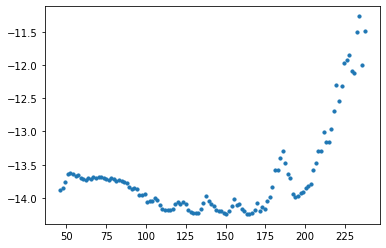

In [59]:
plt.scatter(binary.time.values, -2.5*np.log10(binary.aperture_sum_bkgsub_local.astype(float)), s=10)

In [60]:
import astropy.units as u
Vstar2 = 12.00
uVstar2 = 0.21
pstar2 = 1.5002 * u.mas 
upstar2 = 0.0129 * u.mas
Vstar3 = 14.69
uVstar3 = 0.08
pstar3 = 0.9215 * u.mas
upstar3 = 0.0207 * u.mas
Vstar4 = 13.15
uVstar4 = 0.05
pstar4 = 1.8988
upstar4 = 0.0183

Vstars = np.array([Vstar2, Vstar3, Vstar4])
uVstars = np.array([uVstar2, uVstar3, uVstar4])
#np.concatenate(np.repeat([Vstars], 120, axis=0))

In [61]:
[(357,1228), (614,1468), (660,1585)]

[(357, 1228), (614, 1468), (660, 1585)]

In [62]:
comp1['Amag'] = -2.5 * np.log10(comp1.aperture_sum_bkgsub_local.values.astype(float));
comp1['Vmag'] = np.concatenate(np.repeat([Vstars], 120, axis=0));
comp1['uVmag'] = np.concatenate(np.repeat([uVstars], 120, axis=0));
# comp1['Vmag'] = np.concatenate(np.repeat([Vstars], 212, axis=0));
# comp1['uVmag'] = np.concatenate(np.repeat([uVstars], 212, axis=0));

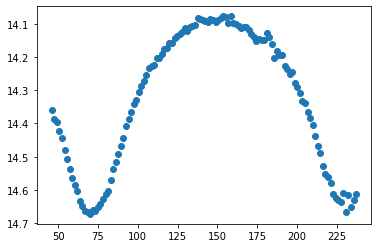

In [63]:
fig, ax = plt.subplots()
binmags = - 2.5 * np.log10(binary.aperture_sum_bkgsub_local.values.astype(float)/comp1.loc[comp1.star==2].aperture_sum_bkgsub_local.values.astype(float))
mag = binmags + 12.00
plt.scatter(time1, mag)
ax.invert_yaxis()

In [64]:
comp1["Vmag"]

1    12.00
2    14.69
3    13.15
1    12.00
2    14.69
     ...  
2    14.69
3    13.15
1    12.00
2    14.69
3    13.15
Name: Vmag, Length: 360, dtype: float64

In [65]:
test = comp1.iloc[0:3]
np.mean(test.Vmag+test.Amag)
np.std(test.Vmag+test.Amag)


1.7131108066291076

In [66]:
dtime.iloc[0].Amag

NameError: name 'dtime' is not defined

In [67]:
mjdt1 = np.array(aimgf1.summary['mjd-obs'].value)
dVavgs = []
corrs = []
corr1 = []
corr2 = []
corr3 = []
for i,t in enumerate(time1):
    dtime = comp1.loc[comp1.time.values==t]
    dV = dtime.Vmag.values - (2.5*np.log10(dtime.aperture_sum_bkgsub_local.values.astype(float)))
    dVl = dtime.Vmag.values - dtime.uVmag.values - (2.5*np.log10(dtime.aperture_sum_bkgsub_local.values.astype(float)))
    dVh = dtime.Vmag.values + dtime.uVmag.values - (2.5*np.log10(dtime.aperture_sum_bkgsub_local.values.astype(float)))
    dVavg = np.mean(dV)
    dVavgs.append(dVavg)
    dVhavg = np.mean(dVh) - dVavg
    dVlavg = dVavg - np.mean(dVl)
    binmag = 2.5 * np.log10(binary.loc[binary.time.values==t].aperture_sum_bkgsub_local.values.astype(float))
    #plt.scatter(t/60, binmag+dVavg, color='k', s=10)
    C = np.mean(-1*dtime.Amag + dtime.Vmag)
    corr1.append(dtime.iloc[0].Vmag-dtime.iloc[0].Amag)
    corr2.append(dtime.iloc[1].Vmag-dtime.iloc[1].Amag)
    corr3.append(dtime.iloc[2].Vmag-dtime.iloc[2].Amag)
    dC = np.sqrt(np.sum(dtime.uVmag**2)) / len(dtime.uVmag)
    corrs.append(C)
dVavgs = np.array(dVavgs)
corrs = np.array(corrs)

In [68]:
corr1 = np.array(corr1)
corr2 = np.array(corr2)
corr3 = np.array(corr3)
dC

0.07673909622147558

14.270979711581294


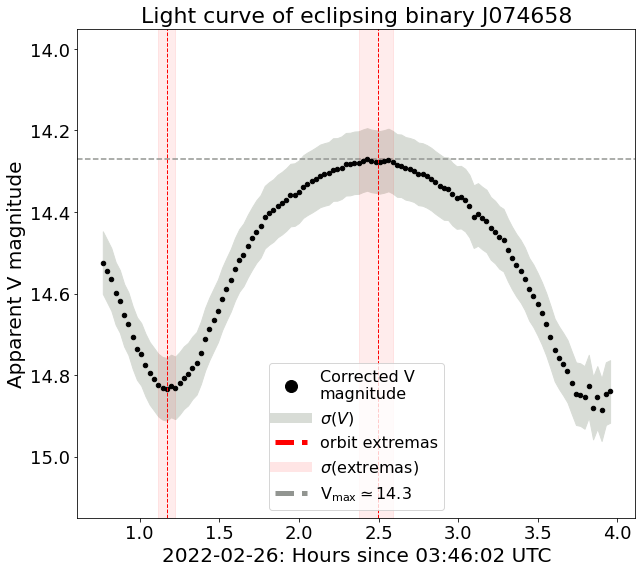

In [69]:
fig, ax = plt.subplots(figsize=(10,9))
binmags = - 2.5 * np.log10(binary.aperture_sum_bkgsub_local.values.astype(float))
maxmag = (binmags+dVavgs).min()
plt.scatter(time1/60, (binmags+corrs), color='k', s=20)
plt.fill_between(time1/60, (binmags+corrs-dC), (binmags+corrs+dC), 
                 zorder=0, color='xkcd:light grey')
plt.xlabel(tobs1[0][:10] + ': ' + 'Hours since '+ tobs1[0][11:] + ' UTC', fontsize=20)
plt.ylabel('Apparent V magnitude', fontsize=20)
ax.tick_params(labelsize=18)
plt.axvline(time1[15]/60, color='r', lw=1, ls='--')
plt.fill_between(np.linspace(time1[13],time1[17],10)/60, 13.9, 15.2, zorder=0, color='r', alpha=0.075)
plt.axvline(149.7/60, color='r', lw=1, ls='--')
plt.axhline((binmags+corrs).min(), zorder=0, color='xkcd:grey', ls='--')
plt.fill_between(np.linspace(time1[60],time1[68],10)/60, 13.9, 15.2, zorder=0, color='r', alpha=0.075)
#plt.axvline(0.16, color='r', lw=1, ls='--')
#plt.fill_between(np.linspace(0.155,0.18,10), 13.9, 15.2, zorder=0, color='r', alpha=0.1)
legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
                   Line2D([0], [0], color='xkcd:light grey', lw=10, label='$\sigma(V)$'),
                    Line2D([0], [0], color='r', lw=5, ls='--', label='orbit extremas'),
                  Line2D([0], [0], color='r', lw=10, alpha=0.1, label=r'$\sigma(\rm{extremas})$'),
                  Line2D([0], [0], color='xkcd:grey', lw=5, ls='--', label=r'V$_{\rm{max}}$'+'$\simeq${:.3}'.format((binmags+corrs).min()))]
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor= (1.01, 0.45), ncol=1,
#             borderaxespad=0, frameon=True, handlelength=3, fontsize=16, markerscale=2)
ax.legend(handles=legend_elements, loc='lower center', ncol=1, frameon=True, 
          handlelength=2, fontsize=16, markerscale=2)
plt.ylim(13.95, 15.15)
ax.invert_yaxis()
ax.set_title('Light curve of eclipsing binary J074658', fontsize=22)
plt.savefig("Binary_Light_Curve.png")
print((binmags + corrs).min())

In [70]:
(149.7-time1[15])*4/60

5.304444444444443

In [71]:
5.6/60

0.09333333333333332

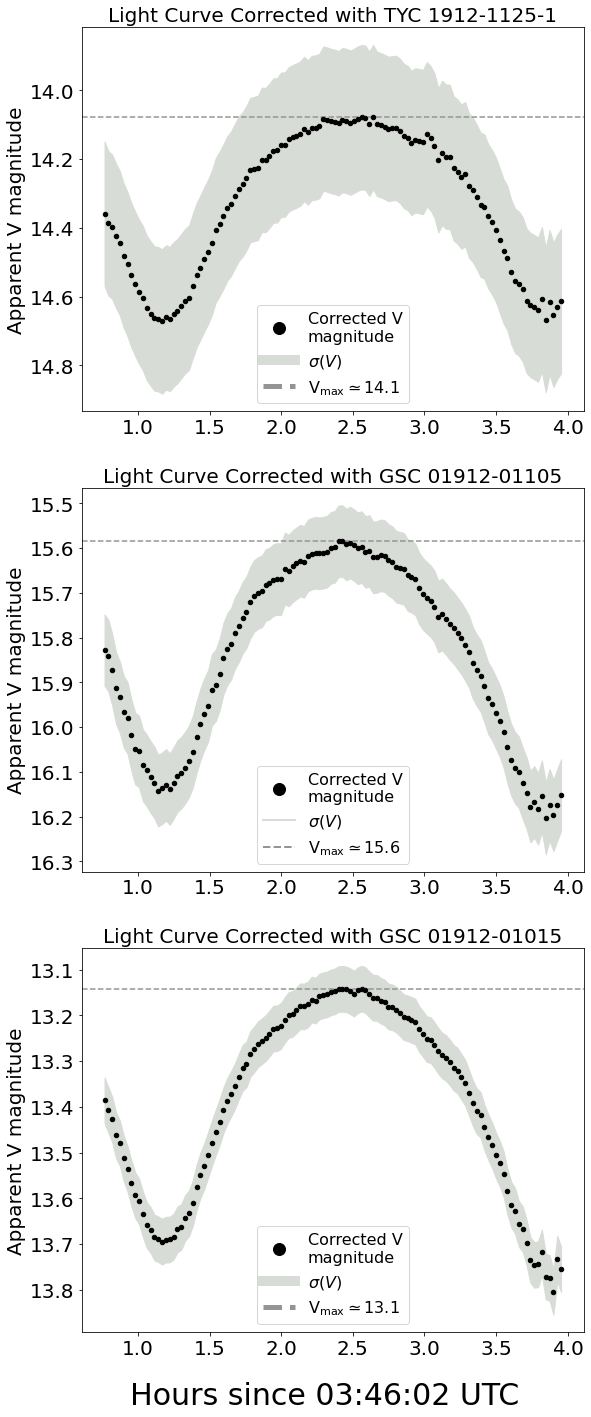

In [72]:
# fig, ax = plt.subplots(1,3,figsize=(20,6))
fig, ax = plt.subplots(3, 1,figsize=(9, 24))


binmags = - 2.5 * np.log10(binary.aperture_sum_bkgsub_local.values.astype(float))
ax[0].scatter(time1/60, (binmags+corr1), color='k', s=20)
ax[0].fill_between(time1/60, (binmags+corr1-0.21), (binmags+corr1+0.21), 
                 zorder=0, color='xkcd:light grey')
ax[0].axhline((binmags+corr1).min(), zorder=0, color='xkcd:grey', ls='--')

legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
                   Line2D([0], [0], color='xkcd:light grey', lw=10, label='$\sigma(V)$'),
                  Line2D([0], [0], color='xkcd:grey', lw=5, ls='--', label=r'V$_{\rm{max}}$'+'$\simeq${:.3}'.format((binmags+corr1).min()))]
ax[0].legend(handles=legend_elements, loc='lower center', ncol=1, frameon=True, 
          handlelength=2, fontsize=16, markerscale=2)

ax[1].scatter(time1/60, (binmags+corr2), color='k', s=20)
ax[1].fill_between(time1/60, (binmags+corr2-0.08), (binmags+corr2+0.08), 
                 zorder=0, color='xkcd:light grey')
ax[1].axhline((binmags+corr2).min(), zorder=0, color='xkcd:grey', ls='--')

legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
                   Line2D([0], [0], color='xkcd:light grey', lw=2, label='$\sigma(V)$'),
                  Line2D([0], [0], color='xkcd:grey', lw=2, ls='--', label=r'V$_{\rm{max}}$'+'$\simeq${:.3}'.format((binmags+corr2).min()))]
ax[1].legend(handles=legend_elements, loc='lower center', ncol=1, frameon=True, 
          handlelength=2, fontsize=16, markerscale=2)

ax[2].scatter(time1/60, (binmags+corr3), color='k', s=20)
ax[2].fill_between(time1/60, (binmags+corr3-0.05), (binmags+corr3+0.05), 
                 zorder=0, color='xkcd:light grey')
ax[2].axhline((binmags+corr3).min(), zorder=0, color='xkcd:grey', ls='--')

legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
                   Line2D([0], [0], color='xkcd:light grey', lw=10, label='$\sigma(V)$'),
                  Line2D([0], [0], color='xkcd:grey', lw=5, ls='--', label=r'V$_{\rm{max}}$'+'$\simeq${:.3}'.format((binmags+corr3).min()))]
ax[2].legend(handles=legend_elements, loc='lower center', ncol=1, frameon=True, 
          handlelength=2, fontsize=16, markerscale=2)

labels=['TYC 1912-1125-1','GSC 01912-01105','GSC 01912-01015']
for i in range(3):
#     ax[i].set_xlabel('Hours since '+ tobs1[0][11:] + ' UTC', fontsize=20)
    ax[i].set_ylabel('Apparent V magnitude', fontsize=20)
    ax[i].tick_params(labelsize=20)
    ax[i].invert_yaxis()
    ax[i].set_title("Light Curve Corrected with {}".format(labels[i]), fontsize=20)
fig.supxlabel('Hours since '+ tobs1[0][11:] + ' UTC', fontsize=30, y=0.08)    
# plt.subplots_adjust(wspace=0.3)
plt.savefig("Cal_Stars_Light_Curve.jpg")

In [73]:
# fig, ax = plt.subplots(figsize=(10,8))
# mag_corr = binmags+dVavgs
# # maxmag = (binmags+dVavgs).max()
# maxmag = mag_corr.max()

# binmags = - 2.5 * np.log10(binary.aperture_sum_bkgsub_local.values.astype(float))
# plt.scatter(time1/60/24, (binmags+dVavgs), color='k', s=20)
# plt.fill_between(time1/60/24, (binmags+dVavgs-dVhavg), (binmags+dVavgs+dVhavg), 
#                  zorder=0, color='xkcd:light grey')
# plt.xlabel(tobs1[0][:10] + ': ' + 'Days since '+ tobs1[0][11:] + ' UTC', fontsize=20)
# plt.ylabel('Apparent V magnitude', fontsize=20)
# ax.tick_params(labelsize=18)
# plt.axvline(time1[15]/60/24, color='r', lw=1, ls='--')
# plt.fill_between(np.linspace(time1[13],time1[17],10)/60/24, 11.5,12.5, zorder=0, color='r', alpha=0.075)
# plt.axvline(149.7/60/24, color='r', lw=1, ls='--')
# plt.axhline(mag_corr.max(), zorder=0, color='xkcd:grey', ls='--')
# plt.fill_between(np.linspace(time1[60],time1[68],10)/60/24, 11.5,12.5, zorder=0, color='r', alpha=0.075)
# #plt.axvline(0.16, color='r', lw=1, ls='--')
# #plt.fill_between(np.linspace(0.155,0.18,10), 11.5,12.5, zorder=0, color='r', alpha=0.1)
# legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
#                    Line2D([0], [0], color='xkcd:light grey', lw=10, label='$\sigma(V)$'),
#                     Line2D([0], [0], color='r', lw=5, ls='--', label='orbit extremas'),
#                   Line2D([0], [0], color='r', lw=10, alpha=0.1, label=r'$\sigma(\rm{extremas})$'),
#                   Line2D([0], [0], color='xkcd:grey', lw=5, ls='--', label=r'V$_{\rm{max}}$'+'$\simeq${:.3}'.format(mag_corr.max()))]
# # plt.ylim(11.5,12.5)
# ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor= (1.01, 0.45), ncol=1,
#             borderaxespad=0, frameon=True, handlelength=3, fontsize=16, markerscale=2)

In [74]:
time1[63]/60/24

0.10225694444444444

In [75]:
(time1[67]+time1[62])/2/60/24

0.1039351851851852

In [76]:
mag_corr = binmags + corrs

[ 0.48267205  1.18996067  0.29536121 14.35175496]


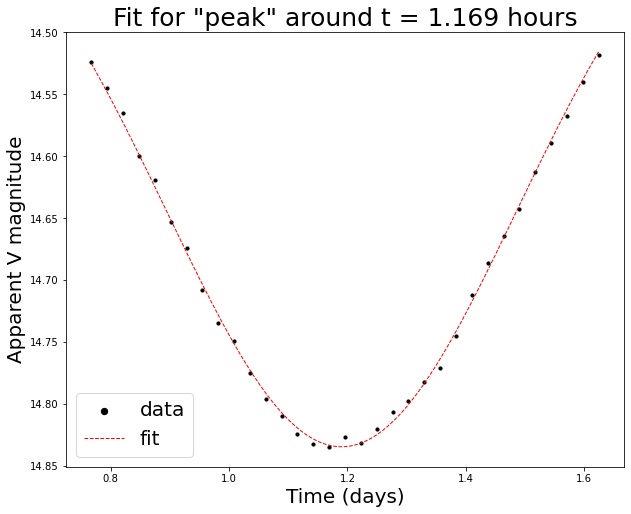

In [77]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = time1[0:33]/60 #np.arange(-30, 31, step) #
y = mag_corr[0:33]#azP

n = len(x)                          #the number of data
mean = np.mean(x)            #note this correction
# sigma = sum(y*(x-mean)**2)/n        #note this correction
sigma = np.std(x)

def gaus(x,a,x0,sigma,c):
#     return a * (x-x0)**2 +c 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

popt2,pcov2 = curve_fit(gaus,x,y, p0=[1, mean, sigma, 14.2]) 
print(popt2)

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(x,y,color='k',label='data',s=10)
plt.plot(np.linspace(x.min(),x.max(),1000),
         gaus(np.linspace(x.min(),x.max(),1000),*popt2),color='r',ls='--',label='fit', lw=1.0)
ax.legend(loc="best", fontsize=20, markerscale=2)
ax.invert_yaxis()
plt.title('Fit for "peak" around t = {:.4} hours'.format(time1[15]/60), fontsize=25)
plt.xlabel('Time (days)', fontsize=20)
plt.ylabel('Apparent V magnitude', fontsize=20)
plt.savefig("day1_1st_lc_peak_fit.jpg")
plt.show()

In [78]:
pcov2
perr2 = np.sqrt(np.diag(pcov2))
perr2

array([0.01775542, 0.00102365, 0.00878484, 0.01852096])

0.10114388401559453
[-2.35990276e+03  1.03639437e-01  2.39204525e+00  2.37417011e+03]


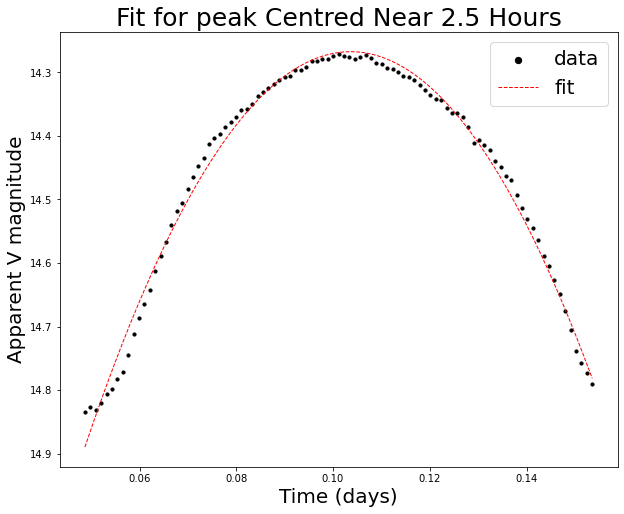

In [79]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = time1[15:110]/60/24 #np.arange(-30, 31, step) #
y = mag_corr[15:110]#azP

n = len(x)                          #the number of data
mean = np.mean(x)            #note this correction
print(mean)
# sigma = sum(y*(x-mean)**2)/n        #note this correction
sigma = np.std(x)

def gaus(x,a,x0,sigma,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

popt,pcov = curve_fit(gaus, x, y, p0=[-1, mean, sigma, 14.6])
print(popt)

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(x,y,color='k',label='data',s=10)
plt.plot(np.linspace(x[0], x[-1],1000),
         gaus(np.linspace(x[0], x[-1],1000),*popt),color='r',ls='--',label='fit', lw=1.0)
plt.legend(loc="best", fontsize=20, markerscale=2)
ax.invert_yaxis()
plt.title('Fit for peak Centred Near 2.5 Hours', fontsize=25)
plt.xlabel('Time (days)', fontsize=20)
plt.ylabel('Apparent V magnitude', fontsize=20)
plt.savefig("day1_2nd_lc_peak_fit.jpg")
plt.show()

In [80]:
pcov
perr = np.sqrt(np.abs(np.diag(pcov)))
perr

array([6.56776851e+05, 1.20967448e-04, 3.32894668e+02, 6.56776857e+05])

In [81]:
(time1[62]-time1[15])/60/24*4

0.20976851851851852

In [96]:
# Calculating Luminosities of stars from Light curve data
au = 1.495978707e11 # m
p = 2.74e-3
up = 0.02e-3

A_plaskett = np.pi * (1.8 / 2) ** 2
D_bin = 206264 / p * au
uD_bin = (206264 / p) *  up * au

K = A_plaskett / D_bin ** 2
uK = K * 2 / (D_bin) * uD_bin

Vmin1 = mag_corr.max()
uVmin = dC
Vmin2 = mag_corr[0:33].max()
Vmax = mag_corr.min()

L1 = 4 / K * 10 ** (-1 * Vmin1 / 2.5) # W
uL1 = np.sqrt((L1 / K * uK) ** 2 + (4 / K * 2 * np.log(10) / (5 * 10 ** (-1 * Vmin1 / 2.5)) * uVmin) ** 2) # W

L2 = 4 / K * (10 ** (-1 * Vmax / 2.5) - 10 ** (-1 * Vmin1 / 2.5)) # W

uL2 = np.sqrt((L2 / K * uK) ** 2 + (4 / K * 2 * np.log(10) / (5 * 10 ** (-1 * Vmin1 / 2.5)) * uVmin) ** 2 + (4 / K * 2 * np.log(10) / (5 * 10 ** (-1 * Vmax / 2.5)) * uVmin) ** 2) # W

f = open("L_and_M.txt", 'w')
L = []
L1string = "The Luminosity of 1 is {} \pm {} Watts \n".format(L1, uL1)
Vm1string = "The first V min is {} \pm {} \n".format(Vmin1, uVmin)
L2string = "The Luminosity of 2 is {} \pm {} Watts \n".format(L2, uL2)
Vm2string = "The second V min is {} \pm {} \n".format(Vmin2, uVmin)
Vmaxstring = "Max V is {} \pm {} \n".format(Vmax, uVmin)
D_binstring = "The distance to the binary is {} \pm {} metres \n".format(D_bin, uD_bin)
Kstring = "The constant K is {} \pm {} \n".format(K, uK)

L.append(D_binstring)
L.append(Kstring)
L.append(Vm1string)
L.append(Vm2string)
L.append(Vmaxstring)
L.append(L1string)
L.append(L2string)


Lsun = 3.828e26 # W
Msun = 1.9885e30 # kg

M1 = Msun * (L1 / (1.4 * Lsun)) ** (2 / 7)
uM1 =  (2 / 7) * Msun * (L1 / (1.4 * Lsun)) ** (-5 / 7) * (1 / (1.4 * Lsun)) * uL1

M2 = Msun * (L2 / (1.4 * Lsun)) ** (2 / 7)
uM2 =  (2 / 7) * Msun * (L2 / (1.4 * Lsun)) ** (-5 / 7) * (1 / (1.4 * Lsun)) * uL2

q = M2 / M1
uq = np.sqrt((1 / M1 * uM2) ** 2 + (-1 * M2 / (M1 ** 2) * uM2) ** 2)

M1string = "Star 1's mass is approximately {} \pm {} kg \n".format(M1, uM1)
M2string = "Star 2's mass is approximately {} \pm {} kg \n".format(M2, uM2)

qstring = "the ratio of the masses, q = M2 / M1 is {} \pm {} \n".format(q, uq)

L.append(M1string)
L.append(M2string)
L.append(qstring)

f.writelines(L)
f.close()

In [97]:
print(L)

['The distance to the binary is 1.1261552993454307e+19 \\pm 225231059869086.16 metres \n', 'The constant K is 2.0064961091245677e-38 \\pm 8.025984436498271e-43 \n', 'The first V min is 14.884951267293175 \\pm 0.07673909622147558 \n', 'The second V min is 14.834657865583523 \\pm 0.07673909622147558 \n', 'Max V is 14.270979711581294 \\pm 0.07673909622147558 \n', 'The Luminosity of 1 is 2.2163643833606298e+32 \\pm 1.2673440681478987e+43 Watts \n', 'The Luminosity of 2 is 1.6851192085217155e+32 \\pm 1.4575656179222695e+43 Watts \n', "Star 1's mass is approximately 8.002978530375068e+31 \\pm 1.3074858015394066e+42 kg \n", "Star 2's mass is approximately 7.400288350986868e+31 \\pm 1.828849989376226e+42 kg \n", 'the ratio of the masses, q = M2 / M1 is 0.9246917660592607 \\pm 31124674004.61877 \n']


## Day 2:

In [37]:
aimgf2.summary

file,simple,bitpix,naxis,naxis1,naxis2,exptime,detector,xbin,ybin,pixsize,ccdtemp,date-obs,ut-date,ut,mjd-obs,obstype,object,st,ra,dec,ha,domeaz,zd,equinox,altitude,airmass,tel_stat,telescop,observat,origin,wind_spd,max_wnd,wind_dir,wind_chl,out_temp,rel_humi,dewpoint,telfocus,filpos,waveleng,bandpass,filter,instrume,pltscale,obsmode,observer,daoprgid,piname,datasec,biassec,expnum,release,subtract_overscan,suboscan,trim_image,trimim,bunit,wcsaxes,crpix1,crpix2,cdelt1,cdelt2,ctype1,ctype2,crval1,crval2,latpole,mjdref,x_shift,y_shift,comment
str23,bool,int64,int64,int64,int64,int64,str5,int64,int64,float64,float64,str19,str10,str8,float64,str6,str16,str11,str11,str11,str12,float64,float64,float64,float64,float64,str5,str5,str3,str7,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str12,str16,float64,str7,str7,str13,str6,str15,str12,str20,str19,str8,str50,str6,str13,str3,int64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,int64,int64,str246
aligned_proc_im212.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:36:16,2022-03-04,04:36:16,59642.19185,object,ecl_bin(150@301),07:10:05.41,07:48:17.99,+22:41:27.6,-00:38:12.57,144.39,26.92,2022.17,63.08,1.1216,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,129.7,1.6,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005162,2023-03-04T04:37:51,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,0,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005162.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-212.fits"
aligned_proc_im213.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:37:53,2022-03-04,04:37:53,59642.19297,object,ecl_bin(150@301),07:11:42.21,07:48:17.78,+22:41:27.7,-00:36:35.56,144.39,26.83,2022.17,63.17,1.1207,TRACK,1.8-m,DAO,NRC/HIA,3.7,3.7,130.6,1.3,4.4,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005163,2023-03-04T04:39:27,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,-1,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005163.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-213.fits"
aligned_proc_im214.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:39:29,2022-03-04,04:39:29,59642.19409,object,ecl_bin(150@301),07:13:19.00,07:48:17.53,+22:41:27.7,-00:34:58.53,144.39,26.75,2022.17,63.25,1.1198,TRACK,1.8-m,DAO,NRC/HIA,3.3,3.3,128.8,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005164,2023-03-04T04:41:04,suboscan,"ccd=<CCDData>, overscan=<CCDData>, overscan_axis=0",trimim,ccd=<CCDData>,adu,2,0.0,0.0,1.0,1.0,PIXEL,PIXEL,0.0,0.0,90.0,0.0,0,-2,"Subtracted plaskett_calibration/raw_master_dark.fits from file plaskett_,images/images_trimmed/dao_c182_2022_005164.fits.gz,Divided plaskett_calibration/master_flat.fits from file plaskett_images/,images_trimmed/im_minus_rmd/im_minus_rmd-214.fits"
aligned_proc_im215.fits,True,-32,2,1020,2307,60,E2V-1,2,2,13.5,-111.7,2022-03-04T04:41:06,2022-03-04,04:41:06,59642.19521,object,ecl_bin(150@301),07:14:55.78,07:48:17.31,+22:41:27.7,-00:33:21.52,144.39,26.67,2022.17,63.33,1.119,TRACK,1.8-m,DAO,NRC/HIA,3.2,3.2,134.0,1.5,4.3,95.0,3.7,8724,3,6200,1300,SDSS r prime,Newtonian Imager,22.5,Imaging,Robotic,DAO182_2022A5,Stairs,"[5:1015,1:2306]","[1:4,1:2306]",dao_c182_2022_005165,2023-03-04T04:42:40,suboscan,"ccd=<CCDData>, overscan=<CCDD

In [38]:
# Initial guess:
target2 = (590,1125)
comp2 = [(332,1166), (589,1406), (636,1523)]
ourstars2 = [(590,1125), (332,1166), (589,1406), (636,1523)]

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


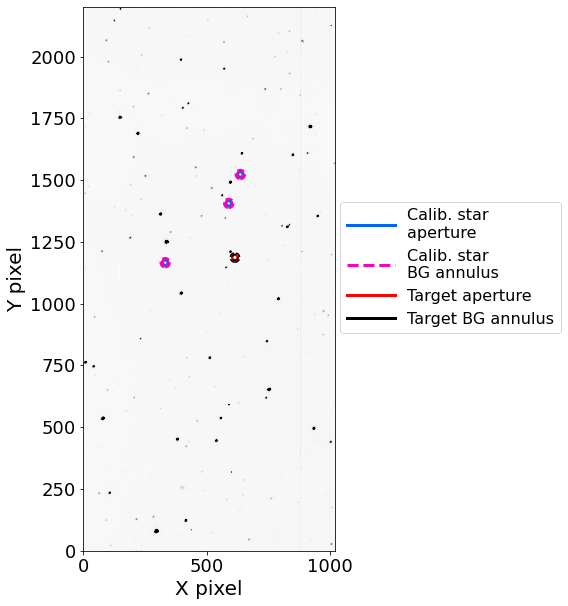

In [39]:
exproc = CCDData.read(aimg_path2/aimgf2.files[0], unit='adu')
fig, ax = plt.subplots(figsize=(10,10))
show_image(exproc, cmap='Greys', percl=99.9, fig=fig, ax=ax, show_colorbar=False)
apertures = CircularAperture(target, r=11.);
apertures.plot(color='r', lw=2.5, alpha=1);
apertures = CircularAperture(target, r=12.);
apertures.plot(color='xkcd:black', ls='--', lw=1.5, alpha=1);
apertures = CircularAperture(target, r=19.);
apertures.plot(color='xkcd:black', lw=1.5, ls='--', alpha=1);

rvals = [11, 11, 11, 11]
for r, compstar in enumerate(comp2):
    apertures = CircularAperture(compstar, r=rvals[r]);
    apertures.plot(color='xkcd:bright blue', lw=3, alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r]+2);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r]+8);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
#plt.xlim(250,750)
plt.ylim(top=2200)
ax.tick_params(labelsize=18)
plt.xlabel('X pixel', fontsize=20)
plt.ylabel('Y pixel', fontsize=20)

legend_elements = [Line2D([0], [0], lw=3, color='xkcd:bright blue', ls='-', label='Calib. star\naperture'),
                   Line2D([0], [0], lw=3, color='xkcd:bright pink', ls='--', label='Calib. star\nBG annulus'),
                   Line2D([0], [0], color='r', lw=3, label='Target aperture'),
                  Line2D([0], [0], color='k', lw=3, label='Target BG annulus')]

ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor= (1.02, 0.4), ncol=1,
            borderaxespad=0, frameon=True, handlelength=3, fontsize=16)

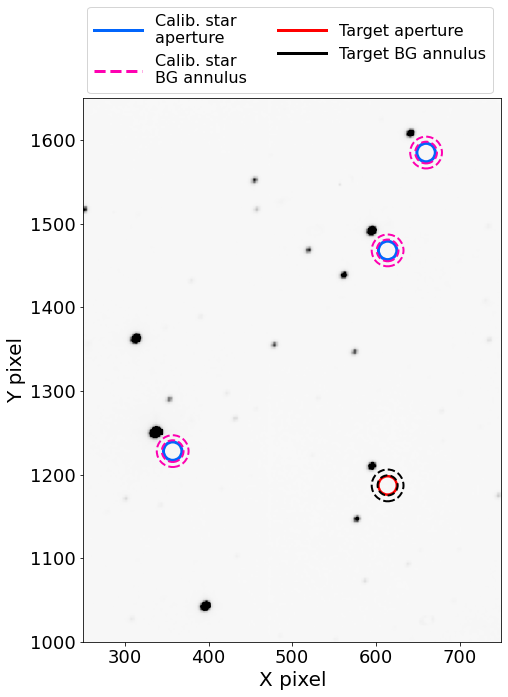

In [40]:
# Zoomed in:

fig, ax = plt.subplots(figsize=(10,10))
show_image(exproc, cmap='Greys', percl=99.9, fig=fig, ax=ax, show_colorbar=False)
apertures = CircularAperture(target, r=11.);
apertures.plot(color='r', lw=2.5, alpha=1);
apertures = CircularAperture(target, r=12.);
apertures.plot(color='k', ls='--', lw=2, alpha=1);
apertures = CircularAperture(target, r=19.);
apertures.plot(color='k', lw=2, ls='--', alpha=1);

rvals = [11, 11, 11, 11]
for r, compstar in enumerate(comp):
    apertures = CircularAperture(compstar, r=rvals[r+1]);
    apertures.plot(color='xkcd:bright blue', lw=3, alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r+1]+2);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
    apertures = CircularAperture(compstar, r=rvals[r+1]+8);
    apertures.plot(color='xkcd:bright pink', lw=2, ls='--', alpha=1);
plt.xlim(250,750)
plt.ylim(1000,1650)
ax.tick_params(labelsize=18)
plt.xlabel('X pixel', fontsize=20)
plt.ylabel('Y pixel', fontsize=20)

legend_elements = [Line2D([0], [0], lw=3, color='xkcd:bright blue', ls='-', label='Calib. star\naperture'),
                   Line2D([0], [0], lw=3, color='xkcd:bright pink', ls='--', label='Calib. star\nBG annulus'),
                   Line2D([0], [0], color='r', lw=3, label='Target aperture'),
                  Line2D([0], [0], color='k', lw=3, label='Target BG annulus')]

ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor= (0.01, 1.01), ncol=2,
            borderaxespad=0, frameon=True, handlelength=3, fontsize=16)

In [41]:
phot_table

id,xcenter,ycenter,aperture_sum,total_bkg,aperture_sum_bkgsub
,pix,pix,adu,,
int64,float64,float64,float64,float64,float64
1,614,1187,2131542.9,2092040.8,39502.046
2,357,1228,2576385.9,2137967.7,438418.27
3,614,1468,2300778.1,2148961.9,151816.23
4,660,1585,2189534.3,2120541.6,68992.675


In [42]:
aimg_path2

PosixPath('plaskett_images/images_trimmed/processed_images/aligned/day2')

In [43]:
import pandas as pd
data2 = pd.DataFrame(columns=['time', 'star', 'aperture_sum', 'total_bkg_local', 
                             'aperture_sum_bkgsub_local', 'aperture_sum_bkgsub_global', 'aperstats_sum'])
apertures = CircularAperture(ourstars2, r=11.);
annulus_apertures = CircularAnnulus(ourstars2, r_in=12., r_out=19.)

for i in range(len(aimgf2.files)):
    exproc = CCDData.read(aimg_path2/aimgf2.files[i], unit='adu')

    mask = make_source_mask(exproc, nsigma=3, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(exproc, sigma=3.0, mask=mask)
    phot_table_local = aperture_photometry(exproc - median, apertures)
    
    aperstats = ApertureStats(exproc.data, annulus_apertures)
    sums = aperstats.sum
    bkg_mean = aperstats.median
    phot_table = aperture_photometry(exproc, apertures)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    aperture_area = apertures.area_overlap(exproc)
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'].value - total_bkg

    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    
    dat = np.array([time2[i]*np.ones(4), phot_table['id'].value.astype(int), phot_table['aperture_sum'].value.astype(float),
                    phot_table['total_bkg'].value.astype(float), phot_table['aperture_sum_bkgsub'].value.astype(float), 
                    phot_table_local['aperture_sum'].value.astype(float), sums]).T
    data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/tmp/ipykernel_4407/3699152171.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2 = data2.append(pd.DataFrame(dat, columns=data2.columns))


In [44]:
binary2 = data2.loc[data2.star==1]
comp2 = data2.loc[data2.star.isin([2,3,4])]

/home/jrushton/Programs/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


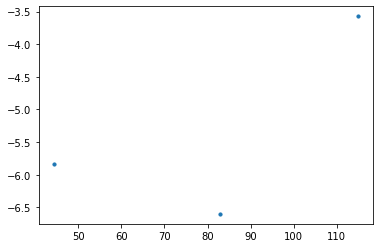

In [45]:
plt.scatter(binary2.time.values, -2.5*np.log10(binary2.aperture_sum_bkgsub_local.astype(float)), s=10)

AttributeError: 'DataFrame' object has no attribute 'Vmag'

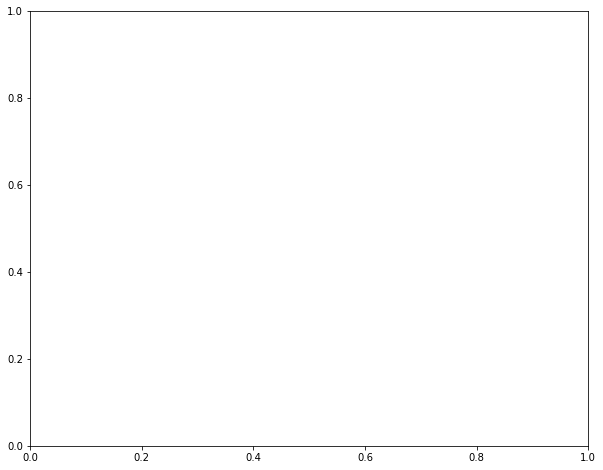

In [46]:
mjdt1 = np.array(aimgf1.summary['mjd-obs'].value)
dVavgs = []
fig, ax = plt.subplots(figsize=(10,8))
for i,t in enumerate(time2):
    dtime = comp2.loc[comp2.time.values==t]
    dV = dtime.Vmag.values - (2.5*np.log10(dtime.aperstats_sum.values.astype(float)))
    dVl = dtime.Vmag.values - dtime.uVmag.values - (2.5*np.log10(dtime.aperstats_sum.values.astype(float)))
    dVh = dtime.Vmag.values + dtime.uVmag.values - (2.5*np.log10(dtime.aperstats_sum.values.astype(float)))
    dVavg = np.mean(dV)
    dVavgs.append(dVavg)
    dVhavg = np.mean(dVh) - dVavg
    dVlavg = dVavg - np.mean(dVl)
    binmag = 2.5 * np.log10(binary2.loc[binary2.time.values==t].aperstats_sum.values.astype(float))
    #plt.scatter(t/60, binmag+dVavg, color='k', s=10)
binmags = 2.5 * np.log10(binary2.aperstats_sum.values.astype(float))
dVavgs = np.array(dVavgs)
maxmag = (binmags+dVavgs).max()
plt.scatter(time2/60, (binmags-dVavgs), color='k', s=20)
#plt.fill_between(time2/60, (binmags+dVavgs-dVhavg), (binmags+dVavgs+dVhavg), zorder=0, color='xkcd:light grey')
plt.xlabel(tobs1[0][:10] + ': ' + 'Hours since '+ tobs1[0][11:] + ' UTC', fontsize=20)
plt.ylabel('Apparent V magnitude', fontsize=20)
ax.tick_params(labelsize=18)

legend_elements = [Line2D([0], [0], marker='o', color='k', ls='', label='Corrected V\nmagnitude'),
                   Line2D([0], [0], color='xkcd:light grey', lw=10, label='$\sigma(V)$')]

#ax.legend(handles=legend_elements, loc='upper left', fontsize=18,markerscale=2)

In [ ]:
comp2['Amag'] = -2.5 * np.log10(comp2.aperstats_sum.values.astype(float));
comp2['Vmag'] = np.concatenate(np.repeat([Vstars], 39, axis=0));
comp2['uVmag'] = np.concatenate(np.repeat([uVstars], 39, axis=0));